In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
with pd.ExcelFile('results.xlsx') as xls:
    df_prices=pd.read_excel(xls,'prices')
    df_state=pd.read_excel(xls,'state')
    df_fuel=pd.read_excel(xls,'fuel')
    df_state_m=pd.read_excel(xls,'state monthwise')


In [3]:
df_prices = df_prices.drop(['customers','revenue' ,'sales'],axis=1).loc[df_prices.price>0].loc[df_prices.sector!='other']

In [4]:
df_prices=df_prices[df_prices.sector!='transportation']
df_prices.head()

,state,sector,price,date
0,WY,all sectors,4.31,2001-01-01
1,WY,commercial,5.13,2001-01-01
2,WY,industrial,3.26,2001-01-01
4,WY,residential,6.01,2001-01-01
6,SC,residential,7.36,2001-01-01


In [5]:
df_prices = df_prices.pivot(columns='sector',index=['state','date'],values='price').rename_axis(columns=None).reset_index()

In [6]:
df_state.head()

,state,fossil,geo,hydro,nuclear,secondary,solar,wind,year
0,AK,5.397155e+06,NaN,1.345665e+06,NaN,NaN,NaN,950.000,2001
1,AL,8.199366e+07,NaN,8.767245e+06,30357063.0,4197177.925,NaN,NaN,2001
2,AR,2.835076e+07,NaN,2.548251e+06,14780789.0,1512231.853,NaN,NaN,2001
3,AZ,5.324790e+07,NaN,7.623565e+06,28724076.0,38948.000,489.0,NaN,2001
4,CA,1.183523e+08,1.218129e+07,2.552842e+07,33219520.0,5610656.253,542271.0,3425953.887,2001


In [7]:
df_fuel.head()

,fuel_category,date,units_MWHr
0,fossil,2001-01-01,2.385061e+08
1,nuclear,2001-01-01,6.870708e+07
2,hydro,2001-01-01,1.885205e+07
3,secondary,2001-01-01,5.391527e+06
4,geo,2001-01-01,1.229325e+06


In [8]:
df_state_m.head()

,state,date,fossil,geo,hydro,nuclear,secondary,solar,wind
0,AK,2001-01-01,485509.641,NaN,104549.118,NaN,NaN,NaN,86.518
1,AK,2001-02-01,455981.194,NaN,90110.610,NaN,NaN,NaN,74.121
2,AK,2001-03-01,487191.377,NaN,99843.153,NaN,NaN,NaN,80.502
3,AK,2001-04-01,404013.012,NaN,84614.771,NaN,NaN,NaN,70.577
4,AK,2001-05-01,399488.266,NaN,85130.287,NaN,NaN,NaN,69.214


In [9]:
df = pd.merge(df_state_m,df_prices,on=['state','date'])


In [10]:
df.describe()

,date,fossil,geo,hydro,nuclear,secondary,solar,wind,all sectors,commercial,industrial,residential
count,14076,1.407600e+04,1.572000e+03,1.324800e+04,8.364000e+03,13596.000000,6.828000e+03,9.564000e+03,14076.000000,14076.000000,14076.000000,14076.000000
mean,2012-06-16 01:44:20.869565184,4.442731e+06,2.242274e+05,4.660079e+05,2.173034e+06,117143.293848,1.175259e+05,3.943773e+05,10.089632,10.141062,7.462951,12.126957
min,2001-01-01 00:00:00,-1.094000e+03,-1.400000e+02,0.000000e+00,-2.967700e+04,-2107.450000,-3.000000e+00,0.000000e+00,3.780000,3.990000,0.960000,4.950000
25%,2006-09-23 12:00:00,1.458648e+06,9.747097e+03,4.610127e+04,8.888210e+05,11446.240500,1.571274e+03,1.567706e+04,7.590000,7.800000,5.370000,9.190000
50%,2012-06-16 00:00:00,3.170151e+06,2.148374e+04,1.232591e+05,1.568446e+06,67742.073000,1.105386e+04,9.031150e+04,9.150000,9.350000,6.500000,11.300000
75%,2018-03-08 18:00:00,6.063440e+06,2.256549e+05,3.210343e+05,2.929554e+06,172258.118603,6.359874e+04,3.871717e+05,11.220000,11.250000,8.110000,13.592500
max,2023-12-01 00:00:00,4.254309e+07,1.149988e+06,1.121010e+07,8.883354e+06,777237.983000,4.703238e+06,1.301731e+07,42.760000,43.650000,40.190000,45.590000
std,NaN,4.902648e+06,3.754253e+05,1.085493e+06,1.764843e+06,138916.732043,3.769673e+05,9.289747e+05,4.122064,3.913562,3.684133,4.590515


In [11]:
df.head()

,state,date,fossil,geo,hydro,nuclear,secondary,solar,wind,all sectors,commercial,industrial,residential
0,AK,2001-01-01,485509.641,NaN,104549.118,NaN,NaN,NaN,86.518,9.97,9.70,7.05,11.22
1,AK,2001-02-01,455981.194,NaN,90110.610,NaN,NaN,NaN,74.121,9.92,9.85,7.23,11.39
2,AK,2001-03-01,487191.377,NaN,99843.153,NaN,NaN,NaN,80.502,10.91,10.46,8.58,12.21
3,AK,2001-04-01,404013.012,NaN,84614.771,NaN,NaN,NaN,70.577,10.59,10.21,7.98,11.98
4,AK,2001-05-01,399488.266,NaN,85130.287,NaN,NaN,NaN,69.214,10.55,10.21,7.65,12.13


<Axes: >

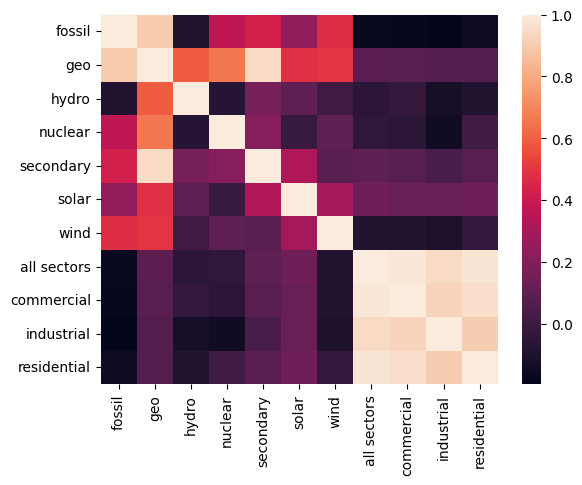

In [12]:
sns.heatmap(data=df.drop(['state','date'],axis=1).corr())

In [13]:
df=df.fillna(0)

In [14]:
from sklearn.pipeline import Pipeline

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV

#Generate metrics for model
from sklearn.metrics import classification_report

import numpy as np

In [15]:
df['year']=df.date.dt.year
df['month']=df.date.dt.month

In [16]:
df=df.drop('date',axis=1)

In [17]:
df=pd.get_dummies(data=df)

In [18]:
df

,fossil,geo,hydro,nuclear,secondary,solar,wind,all sectors,commercial,industrial,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,485509.641,0.0,104549.118,0.0,0.000,0.0,86.518,9.97,9.70,7.05,...,False,False,False,False,False,False,False,False,False,False
1,455981.194,0.0,90110.610,0.0,0.000,0.0,74.121,9.92,9.85,7.23,...,False,False,False,False,False,False,False,False,False,False
2,487191.377,0.0,99843.153,0.0,0.000,0.0,80.502,10.91,10.46,8.58,...,False,False,False,False,False,False,False,False,False,False
3,404013.012,0.0,84614.771,0.0,0.000,0.0,70.577,10.59,10.21,7.98,...,False,False,False,False,False,False,False,False,False,False
4,399488.266,0.0,85130.287,0.0,0.000,0.0,69.214,10.55,10.21,7.65,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,3561549.633,0.0,52150.435,0.0,7502.356,19674.0,545853.540,8.79,10.05,7.40,...,False,False,False,False,False,False,False,False,False,True
14072,2907624.268,0.0,40594.580,0.0,7959.364,17129.0,544336.194,8.64,10.15,7.28,...,False,False,False,False,False,False,False,False,False,True
14073,3135331.086,0.0,39795.367,0.0,7741.733,13155.0,637403.721,8.49,10.21,7.05,...,False,False,False,False,False,False,False,False,False,True
14074,2811242.100,0.0,47015.170,0.0,8461.435,8312.0,966813.784,8.34,10.09,6.92,...,False,False,False,False,False,False,False,False,False,True


In [19]:
X=df.drop(['all sectors','commercial','industrial','residential'],axis=1)
y=df[['all sectors','commercial','industrial','residential']]

In [20]:
pipeline = Pipeline([
    ('clf',MultiOutputRegressor(LinearRegression()))
], verbose=True)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
pipeline.get_params()

{'memory': None,
 'steps': [('clf', MultiOutputRegressor(estimator=LinearRegression()))],
 'verbose': True,
 'clf': MultiOutputRegressor(estimator=LinearRegression()),
 'clf__estimator__copy_X': True,
 'clf__estimator__fit_intercept': True,
 'clf__estimator__n_jobs': None,
 'clf__estimator__positive': False,
 'clf__estimator': LinearRegression(),
 'clf__n_jobs': None}

In [23]:
pipeline.fit(X_train,y_train).score(X_test, y_test)


[Pipeline] ............... (step 1 of 1) Processing clf, total=   0.1s


0.8668554867854813

In [24]:
y_pred=pipeline.predict(X_test)

In [25]:
y_pred[0]

array([13.60568632, 12.8347098 , 11.32209316, 15.24287048])

In [26]:
y_test.iloc[0]


all sectors    13.94
commercial     14.01
industrial     11.90
residential    14.92
Name: 4035, dtype: float64

In [27]:
((y_pred-y_test)**2).mean(axis=0)**0.5


all sectors    1.431873
commercial     1.425822
industrial     1.511057
residential    1.603937
dtype: float64

In [28]:
from sklearn import metrics
metrics.mean_squared_error(y_test,y_pred)**0.5


1.4949196317584816

In [29]:
df_err=(y_test - y_pred).abs()/(y_test)

df_err.melt()

,variable,value
0,all sectors,0.023982
1,all sectors,0.015484
2,all sectors,0.182878
3,all sectors,0.004168
4,all sectors,0.082789
...,...,...
14071,residential,0.045134
14072,residential,0.097910
14073,residential,0.120780
14074,residential,0.009190


In [30]:
df_err=df_err.melt()
df_err

,variable,value
0,all sectors,0.023982
1,all sectors,0.015484
2,all sectors,0.182878
3,all sectors,0.004168
4,all sectors,0.082789
...,...,...
14071,residential,0.045134
14072,residential,0.097910
14073,residential,0.120780
14074,residential,0.009190


In [31]:
import math
df_err['value']=df_err.value.apply(lambda x : 2+math.log10(x))

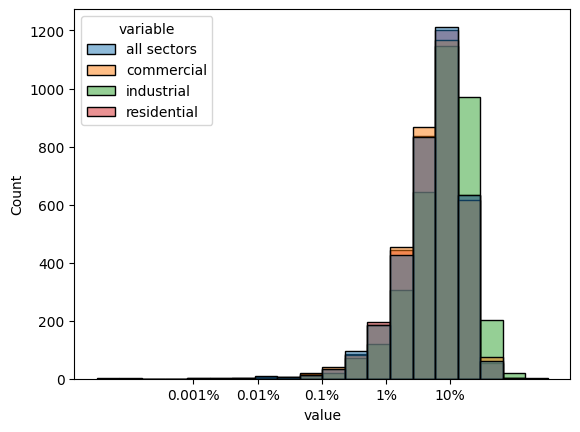

In [32]:
ax = sns.histplot(data=df_err,hue='variable',x='value',bins=20)
ax.set_xticks([-3,-2,-1,0,1])
ax.set_xticklabels(['0.001%', '0.01%', '0.1%','1%','10%']);

In [33]:
metrics.r2_score(y_test,y_pred)

0.8668554867854813

In [34]:
df

,fossil,geo,hydro,nuclear,secondary,solar,wind,all sectors,commercial,industrial,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,485509.641,0.0,104549.118,0.0,0.000,0.0,86.518,9.97,9.70,7.05,...,False,False,False,False,False,False,False,False,False,False
1,455981.194,0.0,90110.610,0.0,0.000,0.0,74.121,9.92,9.85,7.23,...,False,False,False,False,False,False,False,False,False,False
2,487191.377,0.0,99843.153,0.0,0.000,0.0,80.502,10.91,10.46,8.58,...,False,False,False,False,False,False,False,False,False,False
3,404013.012,0.0,84614.771,0.0,0.000,0.0,70.577,10.59,10.21,7.98,...,False,False,False,False,False,False,False,False,False,False
4,399488.266,0.0,85130.287,0.0,0.000,0.0,69.214,10.55,10.21,7.65,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,3561549.633,0.0,52150.435,0.0,7502.356,19674.0,545853.540,8.79,10.05,7.40,...,False,False,False,False,False,False,False,False,False,True
14072,2907624.268,0.0,40594.580,0.0,7959.364,17129.0,544336.194,8.64,10.15,7.28,...,False,False,False,False,False,False,False,False,False,True
14073,3135331.086,0.0,39795.367,0.0,7741.733,13155.0,637403.721,8.49,10.21,7.05,...,False,False,False,False,False,False,False,False,False,True
14074,2811242.100,0.0,47015.170,0.0,8461.435,8312.0,966813.784,8.34,10.09,6.92,...,False,False,False,False,False,False,False,False,False,True


In [35]:
def prediction(energy_util,year,month,state):
    """
    Predict cost of energy for given data.
    Input : 
        - energy_util : tuple of energy generated in megawatt-hours for (fossil, geo, hydro, nuclear, secondary, solar, wind)
        - state
    Output :
        - pred : prediction tuple for ( all sectors, commercial, industrial, residential)
    """
    vec=[i for i in energy_util]+[year,month,state]
    pred= (pipeline.predict(
            pd.DataFrame(
                    data= vec[:9] + [vec[-1] in i for i in X.columns[9:]],
                    index = X.columns).T)  ).round(2)
    actual = df_prices.loc[df_prices.state==state].loc[df_prices.date.dt.year==year].loc[df_prices.date.dt.month==month]
    print("Actual generation for date is:\n",df_state_m.loc[df_state_m.state==state].loc[df_state_m.date.dt.year==year].loc[df_state_m.date.dt.month==month])
    print("Actual prices for data are:\n",actual)
    print("Predicted prices are:\n",pred)
    



In [36]:
df_state_m.iloc[-1000]
prediction((67695310,0,64187,1528077,218557,26532,0),2022,9,'LA')

Actual generation for date is:
       state       date       fossil  geo      hydro    nuclear   secondary  \
13076    LA 2022-09-01  6769530.143  NaN  64187.167  1528077.0  218557.969   

           solar  wind  
13076  26532.734   NaN  
Actual prices for data are:
      state       date  all sectors  commercial  industrial  residential
5228    LA 2022-09-01        11.49       12.79        8.28        14.26
Predicted prices are:
 [[14.52 12.24 12.28 10.92]]


In [37]:
y_pred_all=pipeline.predict(X)

In [38]:
y_pred_all = pd.DataFrame(data=y_pred_all,columns=y.columns)

In [39]:
y_scat = pd.merge(y.melt(),y_pred_all.melt(),left_index=True,right_index=True).drop('variable_x',axis=1)

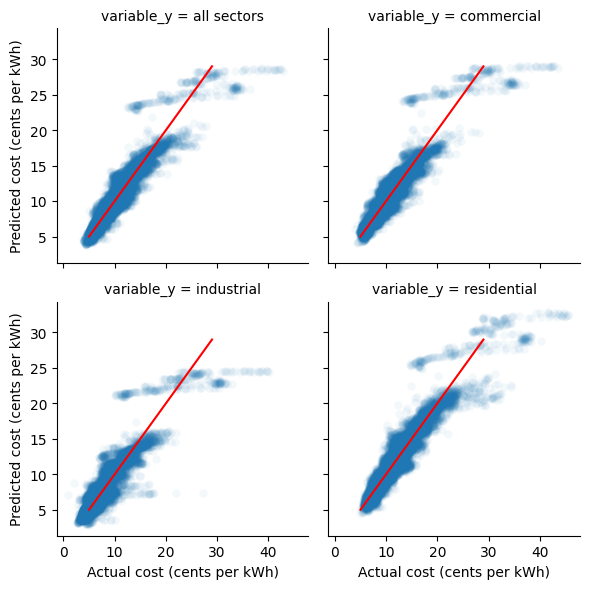

In [43]:

#sns.scatterplot(data=y_scat,x='value_x',y='value_y',hue='variable_y')

graph = sns.FacetGrid(y_scat, col ="variable_y", col_wrap=2)
graph.map(sns.scatterplot, "value_x", "value_y" ,alpha=0.05, linewidth=0)

def const_line(*args, **kwargs):
    x = np.arange(5, 30, 1)
    y = x
    plt.plot(y, x, c='r')

graph.map(const_line)
graph.set_xlabels('Actual cost (cents per kWh)')
graph.set_ylabels('Predicted cost (cents per kWh)')
    